In [41]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, GroupNormalization, ZeroPadding2D, Flatten

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1
2.17.0


In [4]:
def count_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [102]:
monet_filenames = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_filenames))

n_monet_samples = count_items(monet_filenames)
n_photo_samples = count_items(photo_filenames)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [103]:
def decode_image(img):
    features = tf.io.parse_single_example(
        img,
        features={
            'image': tf.io.FixedLenFeature([], tf.string)
        }
    )
    image = features['image']
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    return ds

In [109]:
monet_ds = load_dataset(monet_filenames).batch(1)
photo_ds = load_dataset(photo_filenames).batch(1)

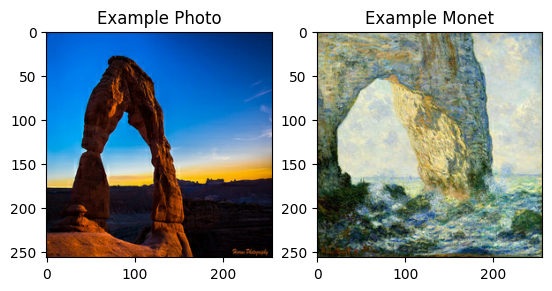

In [111]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(1,2,1)
plt.title('Example Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Example Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [112]:
def Generator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='leaky_relu')
    ])
    return model

def Discriminator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(16, 4, strides=2, padding='same', activation='leaky_relu'),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        ZeroPadding2D(),
        Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        ZeroPadding2D(),
        Conv2D(1, 4, strides=1)
    ])
    return model

In [113]:
with strategy.scope():
    monet_generator = Generator()
    monet_discriminator = Discriminator()
    
    photo_generator = Generator()
    photo_discriminator = Discriminator()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35669917..1.516574].


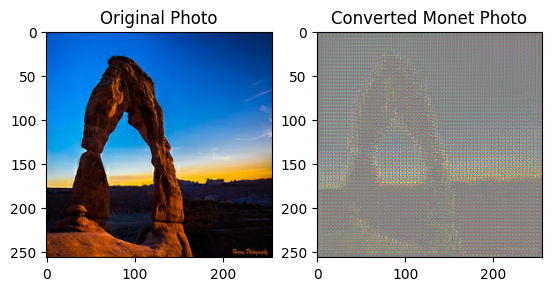

In [117]:
monet_gen_example = monet_generator.predict(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Converted Monet Photo")
plt.imshow(monet_gen_example[0] * 0.5 + 0.5)
plt.show()